# 01 - Classificação com Validação Cruzada Estratificada

Este notebook realiza o pré-processamento, separação de atributos/rótulos e avaliação de três algoritmos supervisionados:
- Árvore de Decisão (Random Forest)
- K-NN (K-Nearest Neighbors)
- MLP (Multi-Layer Perceptron)

A avaliação utiliza F1-score e matriz de confusão via validação cruzada estratificada k-fold, com `random_state` fixo para reprodutibilidade.

Observação: Ajuste o caminho do arquivo da base de dados na seção de carregamento.


In [18]:
import pandas as pd

# Configurações gerais
RANDOM_STATE = 42
N_JOBS = -1
N_SPLITS = 5  # k-fold
TEST_SIZE = 0.2

# Exibição de opções do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    StratifiedKFold, 
    StratifiedGroupKFold,
    cross_validate, 
    cross_val_predict, 
    cross_val_score,
    train_test_split
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    classification_report
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.utils import to_categorical


## Carregamento de dados

Substitua `data/arquivo.csv` pelo caminho real. O rótulo (target) deve estar em uma coluna, por exemplo `target`. Se a base tiver valores ausentes, faremos tratamento na etapa de pré-processamento.


## Pré-processamento

- Identificação de colunas numéricas e categóricas
- Tratamento de valores ausentes
- Padronização de numéricas e One-Hot em categóricas
- Separação de `X` e `y`


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Montando o dataframe

As partes com menor visibilidade e que no geral não são tão importantes para libras serão retiradas do df.

A visibilidade a partir do keypoint 25 (dos Joelhos para baixo) é muito baixa e também não é tão importante na língua de sinais.

Desconsiderei os quadris e o rosto também


In [ ]:

# sinais = pd.read_csv('../data/Sinais/sinais.csv')
# print(sinais.shape)
# print(sinais.head())

# def extrair_metricas_do_arquivo(caminho_arquivo):
#     # Carregando o arquivo JSON
#     sinal = pd.read_json(caminho_arquivo)
#     frames = sinal['frames']
#     dados_keypoints = []

#     # --- Normalização: pega keypoint id=0 do frame 0 como referência ---
#     ref_x, ref_y, ref_z = None, None, None
#     for keypoint in frames[0]['keypoints']:
#         if keypoint['id'] == 0:
#             ref_x, ref_y, ref_z = keypoint['x'], keypoint['y'], keypoint['z']
#             break

#     if ref_x is None:
#         raise ValueError("Frame 0 não contém keypoint id=0!")

#     # Iterando por todos os frames
#     for frame_idx, frame_data in enumerate(frames):
#         for keypoint in frame_data['keypoints']:
#             if 11 <= keypoint['id'] <= 22:
#                 dados_keypoints.append({
#                     'frame': frame_idx,
#                     'id': keypoint['id'],
#                     # Centralização: subtrai o ponto de referência
#                     'x': keypoint['x'] - ref_x,
#                     'y': keypoint['y'] - ref_y,
#                     'z': keypoint['z'] - ref_z,
#                     'visibility': keypoint['visibility']
#                 })

#     # Convertendo para DataFrame
#     df_keypoints = pd.DataFrame(dados_keypoints)

#     # Calculando métricas para cada ID e cada atributo
#     metricas = df_keypoints.groupby('id').agg({
#         'x': ['mean', 'std', 'min', 'max'],
#         'y': ['mean', 'std', 'min', 'max'],
#         'z': ['mean', 'std', 'min', 'max'],
#         'visibility': ['mean', 'std', 'min', 'max']
#     })

#     # Achatando colunas
#     metricas.columns = ['_'.join(col).strip() for col in metricas.columns.values]
#     metricas = metricas.reset_index()

#     # Criando dicionário com todas as métricas
#     metricas_dict = {}
#     for _, row in metricas.iterrows():
#         id_keypoint = int(row['id'])
#         for col in metricas.columns:
#             if col != 'id':
#                 metricas_dict[f'id_{id_keypoint}_{col}'] = row[col]

#     return metricas_dict


# # --- Pipeline de extração de todos os arquivos ---
# resultados = pd.DataFrame()

# for idx, row in sinais.iterrows():
#     caminho_arquivo = f'../data/Sinais/Sinais/{row["file_name"]}'
#     try:
#         metricas_arquivo = extrair_metricas_do_arquivo(caminho_arquivo)
#         temp_df = pd.DataFrame([{**row, **metricas_arquivo}])
#         resultados = pd.concat([resultados, temp_df], ignore_index=True)

#         if idx % 10 == 0:
#             print(f"Processados {idx+1} arquivos de {len(sinais)}")

#     except Exception as e:
#         print(f"Erro ao processar {row['file_name']}: {e}")


In [3]:
sinais = pd.read_csv('../data/Sinais/sinais.csv')
print(sinais.shape)
print(sinais.head())

def extrair_metricas_do_arquivo(caminho_arquivo):
    # Carregando o arquivo JSON
    sinal = pd.read_json(caminho_arquivo)
    frames = sinal['frames']
    dados_keypoints = []

    # --- Normalização: pega keypoint id=0 do frame 0 como referência ---
    ref_x, ref_y = None, None
    for keypoint in frames[0]['keypoints']:
        if keypoint['id'] == 0:
            ref_x, ref_y = keypoint['x'], keypoint['y']
            break

    if ref_x is None:
        raise ValueError("Frame 0 não contém keypoint id=0!")

    # Iterando por todos os frames
    for frame_idx, frame_data in enumerate(frames):
        for keypoint in frame_data['keypoints']:
            if 11 <= keypoint['id'] <= 22:
                dados_keypoints.append({
                    'frame': frame_idx,
                    'id': keypoint['id'],
                    # Centralização: subtrai o ponto de referência
                    'x': keypoint['x'] - ref_x,
                    'y': keypoint['y'] - ref_y,
                    'visibility': keypoint['visibility']
                })

    # Convertendo para DataFrame
    df_keypoints = pd.DataFrame(dados_keypoints)

    # Calculando métricas para cada ID e cada atributo
    metricas = df_keypoints.groupby('id').agg({
        'x': ['mean', 'std', 'min', 'max'],
        'y': ['mean', 'std', 'min', 'max'],
        'visibility': ['mean', 'std', 'min', 'max']
    })

    # Achatando colunas
    metricas.columns = ['_'.join(col).strip() for col in metricas.columns.values]
    metricas = metricas.reset_index()

    # Criando dicionário com todas as métricas
    metricas_dict = {}
    for _, row in metricas.iterrows():
        id_keypoint = int(row['id'])
        for col in metricas.columns:
            if col != 'id':
                metricas_dict[f'id_{id_keypoint}_{col}'] = row[col]

    return metricas_dict


# --- Pipeline de extração de todos os arquivos ---
resultados = pd.DataFrame()

for idx, row in sinais.iterrows():
    caminho_arquivo = f'../data/Sinais/Sinais/{row["file_name"]}'
    try:
        metricas_arquivo = extrair_metricas_do_arquivo(caminho_arquivo)
        temp_df = pd.DataFrame([{**row, **metricas_arquivo}])
        resultados = pd.concat([resultados, temp_df], ignore_index=True)

        if idx % 10 == 0:
            print(f"Processados {idx+1} arquivos de {len(sinais)}")

    except Exception as e:
        print(f"Erro ao processar {row['file_name']}: {e}")


(2502, 7)
           file_name  width  height  duration_sec  num_frames   sinal  \
0  Adição_AP_10.json    738    1008      4.533333         136  Adição   
1   Adição_AP_1.json    774    1006      4.766667         143  Adição   
2   Adição_AP_2.json    760    1002      4.433333         133  Adição   
3   Adição_AP_3.json    762    1000      4.933333         148  Adição   
4   Adição_AP_4.json    764    1004      4.600000         138  Adição   

  interprete  
0    Alexson  
1    Alexson  
2    Alexson  
3    Alexson  
4    Alexson  
Processados 1 arquivos de 2502
Processados 11 arquivos de 2502
Processados 21 arquivos de 2502
Processados 31 arquivos de 2502
Processados 41 arquivos de 2502
Processados 51 arquivos de 2502
Processados 61 arquivos de 2502
Processados 71 arquivos de 2502
Processados 81 arquivos de 2502
Processados 91 arquivos de 2502
Processados 101 arquivos de 2502
Processados 111 arquivos de 2502
Processados 121 arquivos de 2502
Processados 131 arquivos de 2502
Processado

/var/folders/ns/qqkzf_x52rqdpshm0vpl205r0000gn/T/ipykernel_82088/3799803447.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sinal = pd.read_json(caminho_arquivo)


Processados 601 arquivos de 2502
Processados 611 arquivos de 2502
Processados 621 arquivos de 2502
Processados 631 arquivos de 2502
Processados 641 arquivos de 2502
Processados 651 arquivos de 2502
Processados 661 arquivos de 2502
Processados 671 arquivos de 2502
Processados 681 arquivos de 2502
Processados 691 arquivos de 2502
Processados 701 arquivos de 2502
Processados 711 arquivos de 2502
Processados 721 arquivos de 2502
Processados 731 arquivos de 2502
Processados 741 arquivos de 2502
Processados 751 arquivos de 2502
Processados 761 arquivos de 2502
Processados 771 arquivos de 2502
Processados 781 arquivos de 2502
Processados 791 arquivos de 2502
Processados 801 arquivos de 2502
Processados 811 arquivos de 2502
Processados 821 arquivos de 2502
Processados 831 arquivos de 2502
Processados 841 arquivos de 2502
Processados 851 arquivos de 2502
Processados 861 arquivos de 2502
Processados 871 arquivos de 2502
Processados 881 arquivos de 2502
Processados 891 arquivos de 2502
Processado

In [4]:
resultados.head()


,file_name,width,height,duration_sec,num_frames,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_11_visibility_mean,id_11_visibility_std,id_11_visibility_min,id_11_visibility_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_12_visibility_mean,id_12_visibility_std,id_12_visibility_min,id_12_visibility_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_13_visibility_mean,id_13_visibility_std,id_13_visibility_min,id_13_visibility_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_14_visibility_mean,id_14_visibility_std,id_14_visibility_min,id_14_visibility_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_15_visibility_mean,id_15_visibility_std,id_15_visibility_min,id_15_visibility_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_16_visibility_mean,id_16_visibility_std,id_16_visibility_min,id_16_visibility_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_17_visibility_mean,id_17_visibility_std,id_17_visibility_min,id_17_visibility_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_18_visibility_mean,id_18_visibility_std,id_18_visibility_min,id_18_visibility_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_19_visibility_mean,id_19_visibility_std,id_19_visibility_min,id_19_visibility_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_20_visibility_mean,id_20_visibility_std,id_20_visibility_min,id_20_visibility_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_21_visibility_mean,id_21_visibility_std,id_21_visibility_min,id_21_visibility_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max,id_22_visibility_mean,id_22_visibility_std,id_22_visibility_min,id_22_visibility_max
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson,183.845588,2.511835,180.0,190.0,198.169118,4.561603,189.0,203.0,1.0,0.0,1.0,1.0,-156.220588,5.778237,-163.0,-138.0,192.198529,5.374590,180.0,199.0,1.0,0.0,1.0,1.0,239.051471,20.950142,199.0,261.0,460.316176,5.452423,454.0,472.0,1.000000,0.000000,1.00,1.0,-271.669118,65.398387,-369.0,-213.0,406.279412,63.158905,298.0,461.0,1.000000,0.000000,1.00,1.0,64.242647,37.984109,7.0,98.0,505.735294,137.498134,272.0,619.0,0.986985,0.009453,0.97,1.0,-116.463235,64.089163,-226.0,-57.0,454.566176,188.854547,165.0,624.0,0.982868,0.011149,0.97,1.0,16.102941,41.610234,-48.0,53.0,539.911765,187.441664,224.0,689.0,0.964191,0.021101,0.90,0.99,-66.514706,58.612347,-169.0,-11.0,491.823529,227.956100,140.0,692.0,0.951029,0.017139,0.92,0.98,4.889706,32.517727,-48.0,37.0,508.985294,186.493252,197.0,658.0,0.966397,0.019039,0.91,0.99,-39.477941,58.173937,-139.0,16.0,465.352941,215.872168,133.0,656.0,0.953529,0.014065,0.93,0.98,16.073529,31.556799,-34.0,46.0,492.933824,168.908838,211.0,631.0,0.965809,0.018720,0.91,0.99,-47.250000,57.658991,-146.0,9.0,456.227941,201.162583,149.0,635.0,0.950882,0.016621,0.92,0.98
1,Adição_AP_1.json,774,1006,4.766667,143,Adição,Alexson,187.783217,2.368038,184.0,192.0,198.146853,3.339811,191.0,206.0,1.0,0.0,1.0,1.0,-159.727273,5.061845,-167.0,-148.0,200.139860,10.303562,176.0,213.0,1.0,0.0,1.0,1.0,259.811189,15.834510,228.0,286.0,457.321678,5.070769,448.0,469.0,0.998951,0.003075,0.99,1.0,-273.440559,71.486099,-392.0,-213.0,422.454545,78.719034,278.0,480.0,1.000000,0.000000,1.00,1.0,92.076923,39.007778,22.0,125.0,528.734266,134.443818,278.0,623.0,0.986783,0.010319,0.96,1.0,-102.741259,60.358986,-214.0,-52.0,488.517483,197.264920,148.0,642.0,0.980280,0.00

### EDA

Procurando por valores nulos, outliers e outros problemas.

In [5]:
# Análise Exploratória dos Dados

# Verificando as dimensões do dataset
print(f"Dimensões do dataset: {resultados.shape}")

# Verificando os tipos de dados
print("\nTipos de dados:")
print(resultados.dtypes)

# Verificando valores nulos
print("\nValores nulos por coluna:")
print(resultados.isnull().sum())

# Estatísticas descritivas para colunas numéricas
print("\nEstatísticas descritivas para colunas numéricas:")
print(resultados.describe())

# Verificando a distribuição dos sinais (classes)
print("\nDistribuição dos sinais (classes):")
print(resultados['sinal'].value_counts())

# Verificando a distribuição dos intérpretes
print("\nDistribuição dos intérpretes:")
print(resultados['interprete'].value_counts())

# Identificando possíveis outliers em colunas numéricas
print("\nIdentificando outliers em algumas colunas numéricas:")
colunas_numericas = resultados.select_dtypes(include=['int64', 'float64']).columns 

for coluna in colunas_numericas:
    Q1 = resultados[coluna].quantile(0.25)
    Q3 = resultados[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = resultados[(resultados[coluna] < limite_inferior) | (resultados[coluna] > limite_superior)]
    print(f"\nOutliers na coluna {coluna}: {len(outliers)} ({len(outliers)/len(resultados)*100:.2f}%)")

# Criando uma cópia do dataframe para trabalhar com a classificação
df = resultados.copy()

# Criando uma coluna target numérica a partir da coluna 'sinal'
le = LabelEncoder()
df['target'] = le.fit_transform(df['sinal'])

# Mapeamento das classes
print("\nMapeamento das classes (sinal -> target):")
for i, classe in enumerate(le.classes_):
    print(f"{classe} -> {i}")


Dimensões do dataset: (2500, 151)

Tipos de dados:
file_name                 object
width                      int64
height                     int64
duration_sec             float64
num_frames                 int64
sinal                     object
interprete                object
id_11_x_mean             float64
id_11_x_std              float64
id_11_x_min              float64
id_11_x_max              float64
id_11_y_mean             float64
id_11_y_std              float64
id_11_y_min              float64
id_11_y_max              float64
id_11_visibility_mean    float64
id_11_visibility_std     float64
id_11_visibility_min     float64
id_11_visibility_max     float64
id_12_x_mean             float64
id_12_x_std              float64
id_12_x_min              float64
id_12_x_max              float64
id_12_y_mean             float64
id_12_y_std              float64
id_12_y_min              float64
id_12_y_max              float64
id_12_visibility_mean    float64
id_12_visibility_std     

### Retirando elementos com baixa visibilidade

In [6]:
# Definindo um limiar para considerar a visibilidade como baixa
limiar_visibilidade = 0.5

# Criando uma lista para armazenar as linhas com visibilidade baixa
linhas_visibilidade_baixa = []

# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Iterando sobre cada linha do DataFrame
for idx, row in resultados.iterrows():
    # Verificando se alguma coluna de visibilidade média está abaixo do limiar
    colunas_visibilidade_media = [col for col in colunas_visibilidade if 'visibility_mean' in col]
    
    # Se alguma coluna de visibilidade média estiver abaixo do limiar, adiciona à lista
    if any(row[col] < limiar_visibilidade for col in colunas_visibilidade_media):
        linhas_visibilidade_baixa.append(idx)

# Exibindo as linhas com visibilidade baixa
print(f"Foram encontradas {len(linhas_visibilidade_baixa)} linhas com visibilidade média abaixo de {limiar_visibilidade}")

# Selecionando apenas as colunas de visibilidade e informações básicas
colunas_para_exibir = ['file_name', 'sinal', 'interprete'] + colunas_visibilidade

# Exibindo todas as linhas com visibilidade baixa, mas apenas as colunas relacionadas à visibilidade
print("\nLinhas com visibilidade baixa (apenas colunas de visibilidade):")

# Verificando quais sinais têm mais problemas de visibilidade
sinais_problematicos = resultados.iloc[linhas_visibilidade_baixa]['sinal'].value_counts()


# Removendo as linhas com visibilidade baixa do DataFrame
resultados = resultados.drop(linhas_visibilidade_baixa)
print(f"\nDataFrame após remover linhas com visibilidade baixa: {resultados.shape}")


Foram encontradas 10 linhas com visibilidade média abaixo de 0.5

Linhas com visibilidade baixa (apenas colunas de visibilidade):

DataFrame após remover linhas com visibilidade baixa: (2490, 151)


### Remoção de colunas

Vou remover as colunas que nao tem relacao com a classificação

In [7]:
# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Exibindo as colunas que serão removidas
print(f"Removendo {len(colunas_visibilidade)} colunas relacionadas à visibilidade:")
print(colunas_visibilidade)

# Removendo as colunas de visibilidade do DataFrame
resultados = resultados.drop(columns=colunas_visibilidade)
print(f"\nDimensões do DataFrame após remover colunas de visibilidade: {resultados.shape}")

# Removendo colunas que não são relevantes para a classificação
colunas_para_remover = ['file_name', 'duration_sec', 'num_frames', 'width', 'height']
resultados = resultados.drop(columns=colunas_para_remover)
print(f"Dimensões do DataFrame após remover colunas irrelevantes: {resultados.shape}")


Removendo 48 colunas relacionadas à visibilidade:
['id_11_visibility_mean', 'id_11_visibility_std', 'id_11_visibility_min', 'id_11_visibility_max', 'id_12_visibility_mean', 'id_12_visibility_std', 'id_12_visibility_min', 'id_12_visibility_max', 'id_13_visibility_mean', 'id_13_visibility_std', 'id_13_visibility_min', 'id_13_visibility_max', 'id_14_visibility_mean', 'id_14_visibility_std', 'id_14_visibility_min', 'id_14_visibility_max', 'id_15_visibility_mean', 'id_15_visibility_std', 'id_15_visibility_min', 'id_15_visibility_max', 'id_16_visibility_mean', 'id_16_visibility_std', 'id_16_visibility_min', 'id_16_visibility_max', 'id_17_visibility_mean', 'id_17_visibility_std', 'id_17_visibility_min', 'id_17_visibility_max', 'id_18_visibility_mean', 'id_18_visibility_std', 'id_18_visibility_min', 'id_18_visibility_max', 'id_19_visibility_mean', 'id_19_visibility_std', 'id_19_visibility_min', 'id_19_visibility_max', 'id_20_visibility_mean', 'id_20_visibility_std', 'id_20_visibility_min', 'id

In [9]:
resultados.head()

,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max
0,Adição,Alexson,183.845588,2.511835,180.0,190.0,198.169118,4.561603,189.0,203.0,-156.220588,5.778237,-163.0,-138.0,192.198529,5.374590,180.0,199.0,239.051471,20.950142,199.0,261.0,460.316176,5.452423,454.0,472.0,-271.669118,65.398387,-369.0,-213.0,406.279412,63.158905,298.0,461.0,64.242647,37.984109,7.0,98.0,505.735294,137.498134,272.0,619.0,-116.463235,64.089163,-226.0,-57.0,454.566176,188.854547,165.0,624.0,16.102941,41.610234,-48.0,53.0,539.911765,187.441664,224.0,689.0,-66.514706,58.612347,-169.0,-11.0,491.823529,227.956100,140.0,692.0,4.889706,32.517727,-48.0,37.0,508.985294,186.493252,197.0,658.0,-39.477941,58.173937,-139.0,16.0,465.352941,215.872168,133.0,656.0,16.073529,31.556799,-34.0,46.0,492.933824,168.908838,211.0,631.0,-47.250000,57.658991,-146.0,9.0,456.227941,201.162583,149.0,635.0
1,Adição,Alexson,187.783217,2.368038,184.0,192.0,198.146853,3.339811,191.0,206.0,-159.727273,5.061845,-167.0,-148.0,200.139860,10.303562,176.0,213.0,259.811189,15.834510,228.0,286.0,457.321678,5.070769,448.0,469.0,-273.440559,71.486099,-392.0,-213.0,422.454545,78.719034,278.0,480.0,92.076923,39.007778,22.0,125.0,528.734266,134.443818,278.0,623.0,-102.741259,60.358986,-214.0,-52.0,488.517483,197.264920,148.0,642.0,51.965035,43.443084,-21.0,90.0,566.202797,179.724616,235.0,694.0,-45.664336,60.265720,-158.0,9.0,529.671329,230.283193,129.0,708.0,38.937063,35.930531,-21.0,74.0,535.734266,177.897856,209.0,660.0,-17.888112,57.379648,-123.0,31.0,500.237762,215.689101,125.0,671.0,45.916084,33.788175,-10.0,79.0,519.769231,163.030313,220.0,637.0,-28.671329,56.236645,-133.0,21.0,489.846154,202.098125,141.0,651.0
2,Adição,Alexson,187.421053,2.477812,184.0,194.0,192.571429,5.871459,182.0,201.0,-154.511278,5.367716,-162.0,-138.0,192.353383,13.437958,165.0,207.0,253.233083,22.262173,214.0,292.0,448.721805,3.477968,444.0,456.0,-279.172932,73.501032,-383.0,-214.0,400.488722,80.854491,274.0,472.0,79.533835,41.671978,17.0,116.0,493.248120,143.655702,265.0,606.0,-118.368421,66.019565,-219.0,-58.0,444.864662,202.703724,137.0,618.0,35.706767,47.297380,-34.0,79.0,522.827068,189.612025,226.0,673.0,-62.458647,65.518967,-164.0,2.0,479.518797,236.924985,121.0,678.0,24.082707,39.598180,-34.0,65.0,492.992481,187.907879,199.0,643.0,-35.045113,62.289508,-130.0,26.0,454.097744,222.554279,117.0,637.0,32.556391,36.725108,-19.0,69.0,479.864662,172.504228,209.0,615.0,-44.556391,60.457400,-138.0,15.0,445.744361,208.692526,130.0,619.0
3,Adição,Alexson,182.716216,2.013696,181.0,190.0,192.912162,3.524316,188.0,199.0,-160.547297,6.572810,-169.0,-142.0,196.682432,6.556958,184.0,205.0,243.195946,20.924113,204.0,266.0,452.432432,3.164777,448.0,461.0,-279.000000,76.298198,-396.0,-213.0,412.844595,74.202216,286.0,472.0,71.054054,44.122862,3.0,110.0,505.831081,132.287534,286.0,605.0,-118.851351,66.046403,-227.

In [10]:
backup_resultados = resultados.copy()

In [24]:
resultados = backup_resultados.copy()

### Separar features e target
### Separando train e test sets

In [25]:
from sklearn.preprocessing import RobustScaler

# Definindo coluna alvo
TARGET_COL = 'sinal'

# Codificando o target como inteiro e substituindo no DataFrame
label_encoder = LabelEncoder()
resultados[TARGET_COL] = label_encoder.fit_transform(resultados[TARGET_COL])

# Agora sinal já é inteiro no DataFrame
y = resultados[TARGET_COL].copy()

# Features (removendo target e interprete)
feature_cols = [c for c in resultados.columns if c not in [TARGET_COL, 'interprete']]
X = resultados[feature_cols].copy()

# Definindo intérpretes que vão para o conjunto de teste
test_interpretes = ['Dannubia', 'Cecilia']

# Criando máscara de teste/treino
mask_test = resultados['interprete'].isin(test_interpretes)

X_train = X[~mask_test].copy()
y_train = y[~mask_test].copy()

X_test = X[mask_test].copy()
y_test = y[mask_test].copy()

print(f"Conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

# Criando preprocessador para features numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),  # Usando RobustScaler para normalização baseada em mediana e IQR
    ],
    remainder='drop'
)

# Distribuição das classes
print("\nDistribuição das classes nos conjuntos:")
print("Treino:", pd.Series(y_train).value_counts().sort_index())
print("Teste:", pd.Series(y_test).value_counts().sort_index())


Conjunto de treino: X_train=(1990, 96), y_train=(1990,)
Conjunto de teste: X_test=(500, 96), y_test=(500,)

Distribuição das classes nos conjuntos:
Treino: sinal
0     79
1     81
2     80
3     80
4     80
5     80
6     80
7     80
8     80
9     80
10    80
11    80
12    80
13    80
14    80
15    80
16    80
17    80
18    80
19    80
20    70
21    80
22    80
23    80
24    80
Name: count, dtype: int64
Teste: sinal
0     21
1     20
2     20
3     20
4     20
5     20
6     19
7     20
8     20
9     20
10    20
11    20
12    20
13    20
14    20
15    20
16    20
17    20
18    20
19    20
20    20
21    20
22    20
23    20
24    20
Name: count, dtype: int64


### Implementando Random Forest

- Adição: 0
- Aluno: 1
- Antropologia: 2
- Apontador: 3
- Apostila: 4
- Biologia: 5
- Bolsa de Estudos: 6
- Capítulo: 7
- Classe: 8
- Coerência: 9
- Coesão: 10
- Colega: 11
- Conceito: 12
- Contexto: 13
- Curso: 14
- Dicionário: 15
- Disciplina: 16
- Ensinar: 17
- Escola: 18
- Estudar: 19
- Filosofia: 20
- Física: 21
- Geografia: 22
- História: 23
- Ângulo: 24

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer

#pipeline com os melhores parâmetros encontrados
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # irrelevante p/ RF, mas mantém consistência
    ("pca", PCA(n_components=40)),  # melhor PCA encontrado
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        n_estimators=300,          # melhor número de árvores
        max_depth=20,              # melhor profundidade máxima
        min_samples_split=10       # melhor split mínimo
    ))
])

# Grupos correspondem aos intérpretes do conjunto de treino
groups_train = resultados.loc[~mask_test, 'interprete'].values

# Definir StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# F1-score macro
f1_macro = make_scorer(f1_score, average="macro")

# Validação cruzada estratificada com grupos (apenas no treino)
scores = cross_val_score(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=f1_macro,
    groups=groups_train,
    n_jobs=-1
)

print("F1 por fold (grouped CV):", scores)
print("Média do F1-score na validação cruzada:", scores.mean())

# Treinar modelo final com todos os dados de treino
pipeline.fit(X_train, y_train)

# Avaliar no conjunto de teste (Cecilia e Everton)
y_pred = pipeline.predict(X_test)
test_score = f1_score(y_test, y_pred, average="macro")
print(f"F1-score no conjunto de teste final (Dannubia e Cecilia): {test_score:.4f}")


F1 por fold (grouped CV): [0.08486278 0.38411671 0.51111291 0.39749178 0.58762923]
Média do F1-score na validação cruzada: 0.3930426830029462
F1-score no conjunto de teste final (Dannubia e Cecilia): 0.4967


<Figure size 1000x800 with 0 Axes>

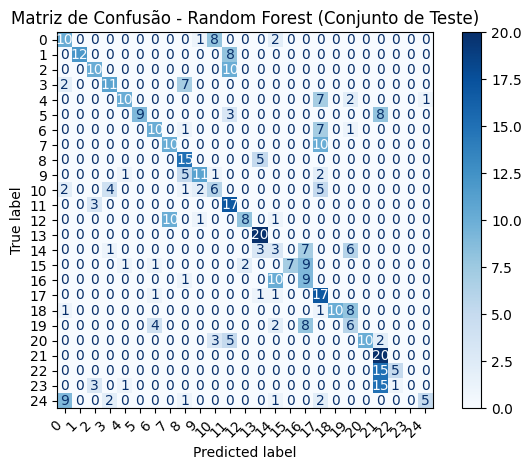


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.42      0.48      0.44        21
           1       1.00      0.60      0.75        20
           2       0.62      0.50      0.56        20
           3       0.61      0.55      0.58        20
           4       0.77      0.50      0.61        20
           5       1.00      0.45      0.62        20
           6       0.62      0.53      0.57        19
           7       0.50      0.50      0.50        20
           8       0.48      0.75      0.59        20
           9       0.73      0.55      0.63        20
          10       0.33      0.30      0.32        20
          11       0.40      0.85      0.54        20
          12       0.80      0.40      0.53        20
          13       0.69      1.00      0.82        20
          14       0.15      0.15      0.15        20
          15       1.00      0.35      0.52        20
          16       0.27      0.45      0.34        2

/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [32]:



# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Random Forest (Conjunto de Teste)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Exibir relatório de classificação detalhado
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


## KNN


In [ ]:
# from sklearn.preprocessing import RobustScaler

# # Definindo coluna alvo
# TARGET_COL = 'sinal'

# # Codificando o target como inteiro para uso posterior
# label_encoder = LabelEncoder()
# resultados['sinal_encoded'] = label_encoder.fit_transform(resultados[TARGET_COL])

# # Features (removendo target e interprete)
# feature_cols = [c for c in resultados.columns if c not in [TARGET_COL, 'interprete', 'sinal_encoded']]
# X = resultados[feature_cols].copy()

# # Definindo intérpretes que vão para o conjunto de teste
# test_interpretes = ['Dannubia', 'Cecilia']

# # Criando máscara de teste/treino
# mask_test = resultados['interprete'].isin(test_interpretes)

# X_train = X[~mask_test].copy()
# X_test = X[mask_test].copy()

# # Obtendo os valores originais do target para one-hot encoding
# y_train = resultados.loc[~mask_test, TARGET_COL].copy()
# y_test = resultados.loc[mask_test, TARGET_COL].copy()

# # Aplicando One-Hot Encoding nos targets
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# y_train = one_hot_encoder.fit_transform(y_train.values.reshape(-1, 1))
# y_test = one_hot_encoder.transform(y_test.values.reshape(-1, 1))

# print(f"Conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
# print(f"Conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

# # Criando preprocessador para features numéricas usando RobustScaler
# numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# preprocess = ColumnTransformer(
#     transformers=[
#         ('num', RobustScaler(), numeric_features),  # Usando RobustScaler para normalização baseada em mediana e IQR
#     ],
#     remainder='drop'
# )

# # Distribuição das classes
# print("\nDistribuição das classes nos conjuntos:")
# print("Treino:", pd.Series(y_train).value_counts().sort_index())
# print("Teste:", pd.Series(y_test).value_counts().sort_index())
# print("\nClasses codificadas:", list(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Resultados do KNN:
Acurácia: 0.4100
F1-Score: 0.3948

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       1.00      1.00      1.00        20
           2       1.00      0.45      0.62        20
           3       0.91      0.50      0.65        20
           4       1.00      0.45      0.62        20
           5       1.00      0.10      0.18        20
           6       0.00      0.00      0.00        19
           7       0.78      0.35      0.48        20
           8       0.03      0.05      0.04        20
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00        20
          11       0.65      1.00      0.78        20
          12       0.89      0.40      0.55        20
          13       1.00      0.80      0.89        20
          14       0.00      0.00      0.00        20
          15       0.83      0.50      0.62        20

/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()


F1-Score com validação cruzada estratificada por grupos (5-fold):
Média: 0.3311, Desvio padrão: 0.1609
Scores individuais: [0.09968153 0.21167072 0.49359322 0.33154488 0.51883387]


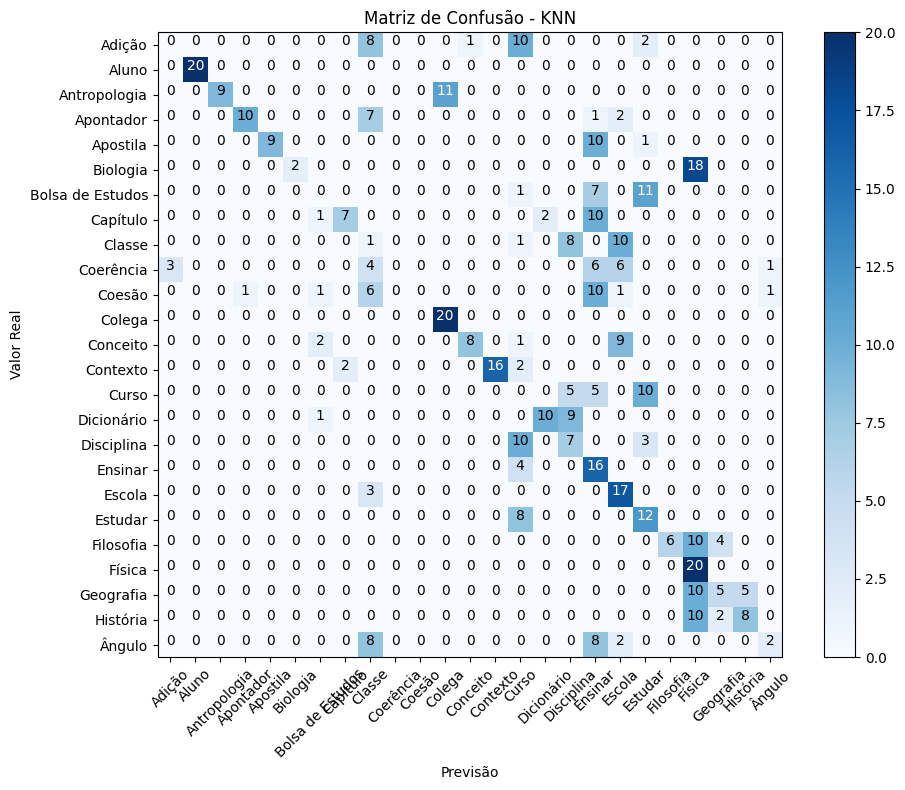

In [27]:
# Implementação do modelo KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold
import matplotlib.pyplot as plt

# Criando o pipeline com preprocessamento e KNN com os melhores hiperparâmetros
knn_pipeline = Pipeline([
    ('preprocess', preprocess),
    ("pca", PCA(n_components=40, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan', p=1))
])

# Treinando o modelo
knn_pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred = knn_pipeline.predict(X_test)

# Avaliando o modelo
print("Resultados do KNN:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

# Validação cruzada para F1-Score usando StratifiedGroupKFold para evitar vazamento de dados
# Isso garante que exemplos do mesmo intérprete não apareçam em diferentes folds
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
groups_train = resultados.loc[~mask_test, 'interprete'].values
f1_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=cv, scoring='f1_macro', groups=groups_train)
print(f"\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {f1_scores.mean():.4f}, Desvio padrão: {f1_scores.std():.4f}")
print(f"Scores individuais: {f1_scores}")

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - KNN')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Previsão')
plt.ylabel('Valor Real')

# Adicionando valores na matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## MLP


Iteration 1, loss = 3.44302827
Iteration 2, loss = 3.13966227
Iteration 3, loss = 2.91475405
Iteration 4, loss = 2.73089937
Iteration 5, loss = 2.56546824
Iteration 6, loss = 2.41762283
Iteration 7, loss = 2.28472800
Iteration 8, loss = 2.16198148
Iteration 9, loss = 2.04775690
Iteration 10, loss = 1.94208781
Iteration 11, loss = 1.84243304
Iteration 12, loss = 1.75033866
Iteration 13, loss = 1.66387509
Iteration 14, loss = 1.58312793
Iteration 15, loss = 1.50710384
Iteration 16, loss = 1.43670158
Iteration 17, loss = 1.37030140
Iteration 18, loss = 1.30767417
Iteration 19, loss = 1.24916720
Iteration 20, loss = 1.19397152
Iteration 21, loss = 1.14284548
Iteration 22, loss = 1.09339551
Iteration 23, loss = 1.04732261
Iteration 24, loss = 1.00446473
Iteration 25, loss = 0.96389455
Iteration 26, loss = 0.92503463
Iteration 27, loss = 0.88888134
Iteration 28, loss = 0.85495055
Iteration 29, loss = 0.82169875
Iteration 30, loss = 0.79105951
Iteration 31, loss = 0.76160149
Iteration 32, los

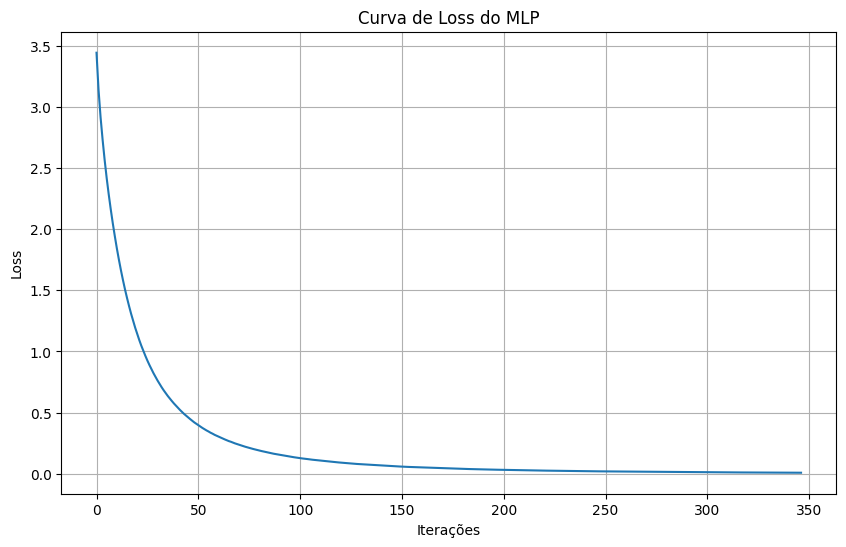

Resultados do MLP:
Acurácia: 0.4940
F1-Score: 0.4705

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.31      0.71      0.43        21
           1       1.00      1.00      1.00        20
           2       1.00      0.50      0.67        20
           3       0.51      0.90      0.65        20
           4       0.00      0.00      0.00        20
           5       1.00      0.45      0.62        20
           6       0.59      0.53      0.56        19
           7       1.00      0.50      0.67        20
           8       0.83      0.50      0.62        20
           9       0.38      0.80      0.52        20
          10       0.20      0.15      0.17        20
          11       0.73      0.95      0.83        20
          12       0.57      0.40      0.47        20
          13       1.00      1.00      1.00        20
          14       0.05      0.05      0.05        20
          15       0.33      0.05      0.09        20

/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Iteration 28, loss = 0.69966030
Iteration 29, loss = 0.66879048
Iteration 30, loss = 0.63938502
Iteration 31, loss = 0.61173840
Iteration 32, loss = 0.58567352
Iteration 33, loss = 0.56186924
Iteration 34, loss = 0.53891737
Iteration 35, loss = 0.51728344
Iteration 36, loss = 0.49666391
Iteration 37, loss = 0.47746149
Iteration 38, loss = 0.45965347
Iteration 39, loss = 0.44281273
Iteration 40, loss = 0.42634187
Iteration 41, loss = 0.41068420
Iteration 42, loss = 0.39598661
Iteration 43, loss = 0.38189127
Iteration 44, loss = 0.36884589
Iteration 45, loss = 0.35648018
Iteration 46, loss = 0.34431926
Iteration 47, loss = 0.33258708
Iteration 48, loss = 0.32179961
Iteration 49, loss = 0.31158075
Iteration 50, loss = 0.30137435
Iteration 51, loss = 0.29234242
Iteration 52, loss = 0.28324009
Iteration 53, loss = 0.27477939
Iteration 54, loss = 0.26636936
Iteration 55, loss = 0.25799837
Iteration 56, loss = 0.25045452
Iteration 57, loss = 0.24300375
Iteration 58, loss = 0.23602921
Iteratio

/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 24, loss = 1.00859983
Iteration 25, loss = 0.96571287
Iteration 26, loss = 0.92547921
Iteration 27, loss = 0.88702090
Iteration 28, loss = 0.85108112
Iteration 29, loss = 0.81682049
Iteration 30, loss = 0.78371697
Iteration 31, loss = 0.75336597
Iteration 32, loss = 0.72423133
Iteration 33, loss = 0.69709927
Iteration 34, loss = 0.67050690
Iteration 35, loss = 0.64505478
Iteration 36, loss = 0.62206896
Iteration 37, loss = 0.59947579
Iteration 38, loss = 0.57995521
Iteration 39, loss = 0.55872624
Iteration 40, loss = 0.53937403
Iteration 41, loss = 0.52053105
Iteration 42, loss = 0.50304670
Iteration 43, loss = 0.48652529
Iteration 44, loss = 0.47045228
Iteration 45, loss = 0.45508672
Iteration 46, loss = 0.44063842
Iteration 47, loss = 0.42686378
Iteration 48, loss = 0.41319048
Iteration 49, loss = 0.40072894
Iteration 50, loss = 0.38814160
Iteration 51, loss = 0.37630947
Iteration 52, loss = 0.36531688
Iteration 53, loss = 0.35478455
Iteration 54, loss = 0.34384332
Iteratio

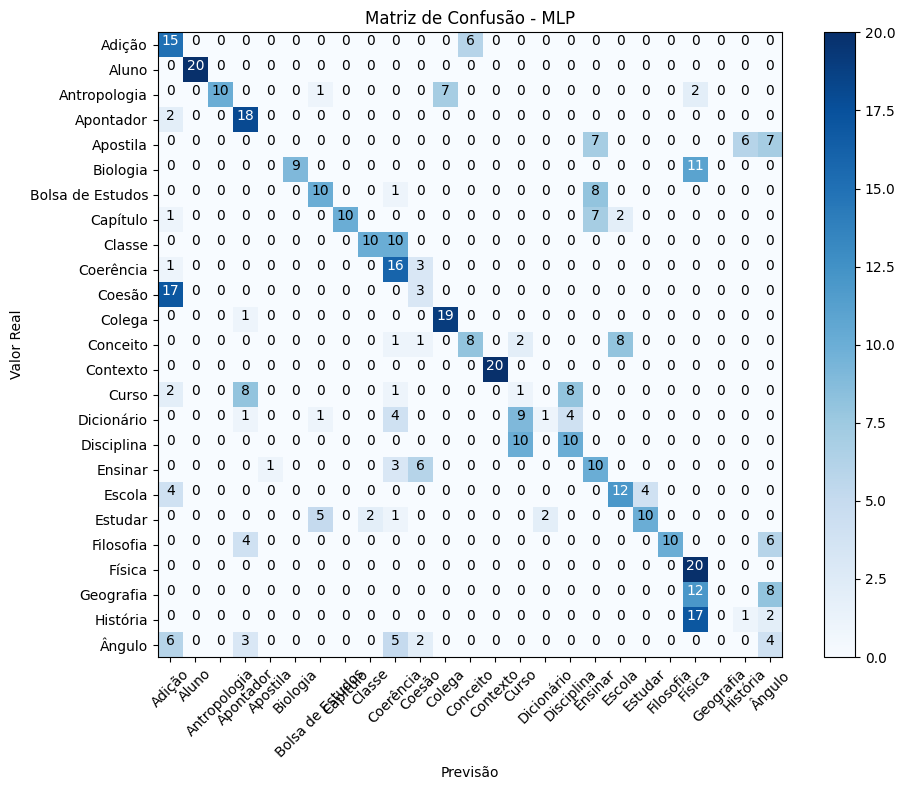

In [30]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold

# Criando o pipeline para o MLP
mlp_pipeline = Pipeline([
    ('preprocess', preprocess),
    ("pca", PCA(n_components=40, random_state=42)),  # opcional, compare com None
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100,),  # Tamanho das camadas ocultas
        activation='relu',          # Função de ativação
        solver='adam',              # Otimizador
        alpha=0.0001,               # Termo de regularização
        batch_size='auto',          # Tamanho do lote
        learning_rate='constant',   # Taxa de aprendizado
        learning_rate_init=0.001,   # Taxa de aprendizado inicial
        max_iter=400,               # Número máximo de iterações
        random_state=RANDOM_STATE,  # Semente aleatória
        verbose=True                # Para obter informações de loss durante o treinamento
    ))
])

# Treinando o modelo
mlp_pipeline.fit(X_train, y_train)

# Extraindo o histórico de loss
mlp = mlp_pipeline.named_steps['mlp']
loss_values = mlp.loss_curve_

# Plotando a curva de loss
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.title('Curva de Loss do MLP')
plt.xlabel('Iterações')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Fazendo previsões
y_pred = mlp_pipeline.predict(X_test)

# Avaliando o modelo
print("Resultados do MLP:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

# Validação cruzada para F1-Score usando StratifiedGroupKFold para evitar vazamento de dados
# Isso garante que exemplos do mesmo intérprete não apareçam em diferentes folds
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
groups_train = resultados.loc[~mask_test, 'interprete'].values
f1_scores = cross_val_score(mlp_pipeline, X_train, y_train, cv=cv, scoring='f1_macro', groups=groups_train)
print(f"\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {f1_scores.mean():.4f}, Desvio padrão: {f1_scores.std():.4f}")
print(f"Scores individuais: {f1_scores}")

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - MLP')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Previsão')
plt.ylabel('Valor Real')

# Adicionando valores na matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## Modelagem e Avaliação (CV Estratificada)

Treinaremos e avaliaremos:
- Random Forest
- KNN
- MLP

Usaremos F1 macro e exibiremos a matriz de confusão a partir de `cross_val_predict` para cada modelo.
